In [3]:
import numpy as np
import sys
import os
sys.path.append(os.environ.get('BASE_PATH'))
from  data_preprocessing import return_dataloaders
from VariationalAutoEncoder import VariationalAutoEncoder
from VariationalCNNAutoEncoder import VariationalCNNAutoEncoder
import torch
import torch.nn as nn
import torchvision
import tqdm.notebook as tq
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Data preparation and transformation

In [4]:
train_dataloader, val_dataloader = return_dataloaders(128, 128)
print(train_dataloader.__len__())

469


In [5]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def train(model, dataloader, criterion, opt, epoch, device=device):
  model.train()
  epoch_loss = 0.0
  for image, _ in tq.tqdm(dataloader):
    image = image.to(device)#.view(-1, 784)
    output, mu, sigma, _  = model(image)
    reconst_loss = criterion(output, image)
    kl_div = - torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

    loss = reconst_loss + kl_div

    opt.zero_grad()
    loss.backward()
    opt.step()

    epoch_loss += loss.item() * image.size(0)
  epoch_loss = epoch_loss / len(dataloader.dataset)
  print(f'Training, Epoch : {epoch} train_loss: {epoch_loss}')
  return model

In [7]:
def plot_results(model, dataloader, epoch,num_images=8):
  img, _ = next(iter(val_dataloader))
  img = img[:num_images, :, :, :]
  fig = plt.figure(figsize=(16,4))
  rows = 2
  columns = 8
  fig.suptitle(f"Epoch {epoch}")
  for i in range(num_images):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img[i][0].reshape(28, 28), cmap='gist_gray')
    plt.axis('off')

    fig.add_subplot(rows, columns, i + 1 + num_images)

    inp = img[i].to(device)
    out, _, __, ___ = model(inp.unsqueeze(0))
    out = out.reshape(28,28).detach().cpu().numpy()
    plt.imshow(out, cmap='gist_gray')
    plt.axis('off')

In [8]:
latent_space_size = 48
model =VariationalCNNAutoEncoder(latent_space_size)
model.to(device)
criterion = nn.BCELoss(reduction="sum")
lr = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.4)

  0%|          | 0/469 [00:00<?, ?it/s]

Training, Epoch : 0 train_loss: 25601.549519791668


  0%|          | 0/469 [00:00<?, ?it/s]

Training, Epoch : 1 train_loss: 13795.921091145834


  0%|          | 0/469 [00:00<?, ?it/s]

Training, Epoch : 2 train_loss: 12546.798174479167


  0%|          | 0/469 [00:00<?, ?it/s]

Training, Epoch : 3 train_loss: 12104.814722916666


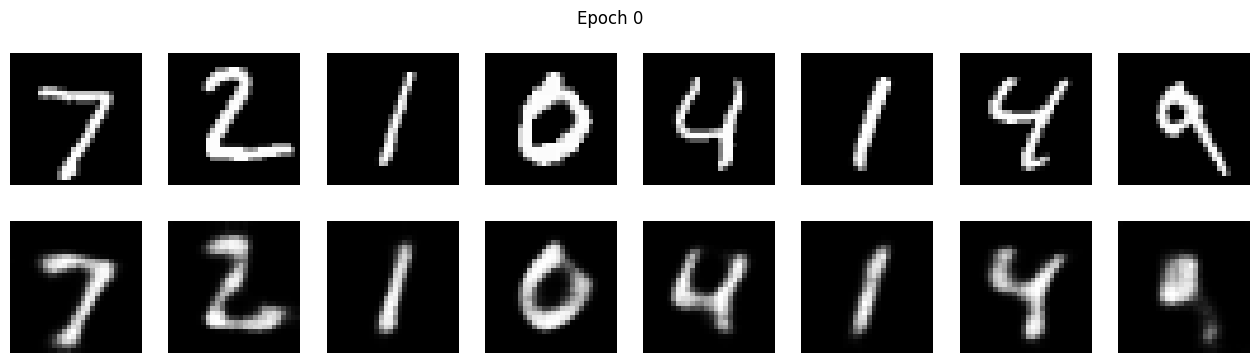

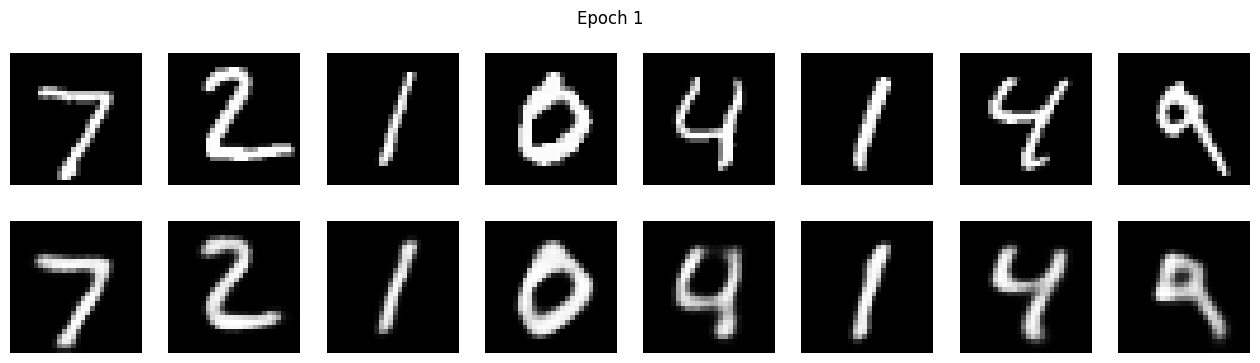

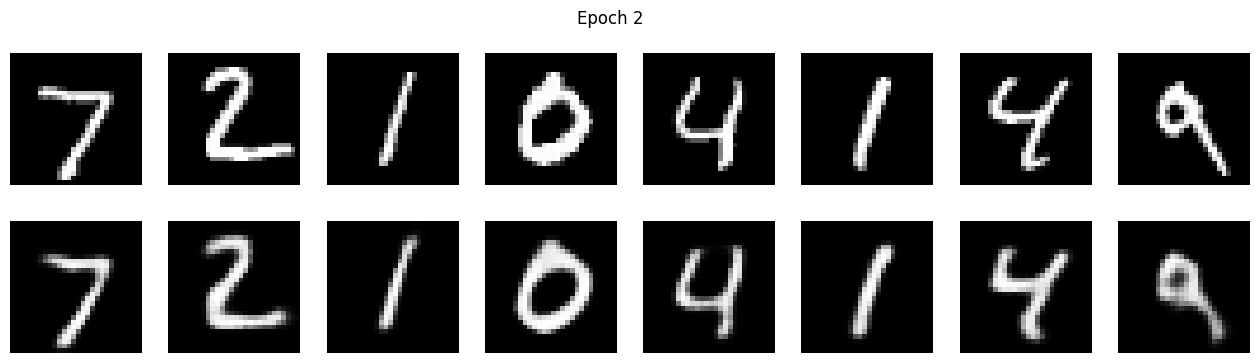

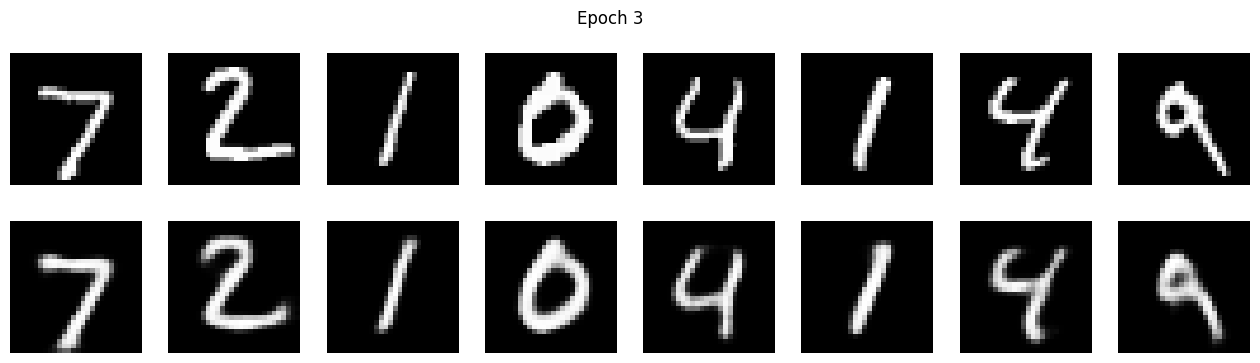

In [11]:
NUM_EPOCHS = 4
for epoch in range(NUM_EPOCHS):
  model = train(model, train_dataloader, criterion, optimizer, epoch)
  plot_results(model, val_dataloader, epoch)

## Taking closer look at the latent space

First, it is important to get encoded latent space. 
To achive this, the data gets to the point when its reparametrizied, and the output
is stored in list for the analysis. Labels are stored as well

In [14]:
encoded_space = []
labels = []

for image, label in val_dataloader:
  image = image.to(device)
  _, __, ___, output = model(image)
  encoded_space.extend(output.detach().cpu().numpy())
  labels.extend(label.detach().cpu().numpy())
encoded_space = np.array(encoded_space).reshape(np.array(encoded_space).shape[0], latent_space_size)

Then, the encoded latent space is plotted with labels attached to them to see how well 
can model tell apart classes
Using TSNE dimension reduction (if latent space > 2), it is possible to distinguish different categories even more

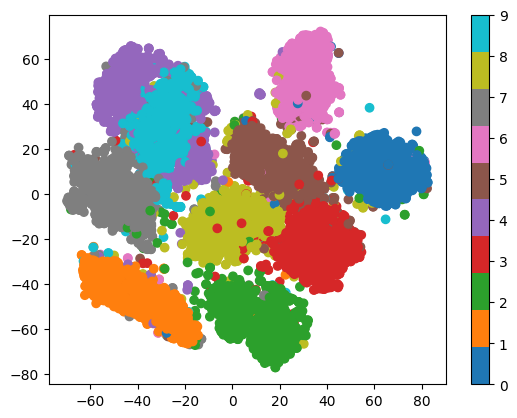

In [13]:
if latent_space_size <= 2:
    plt.scatter(x=encoded_space[:, 0], y=encoded_space[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
else:
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(encoded_space)
    plt.scatter(x=tsne_results[:, 0], y=tsne_results[:, 1], c=labels,cmap='tab10')
    plt.colorbar()